In [1]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from ipywidgets import interact

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from inexact_psgla import *
from psgla import *
from pxmala import *
import distributions as pds
import potentials as pot

**Generate data for the likelihood function**\
Suppose there is a ground truth image $u_{\text{true}}$ which is sparse. Let $u_{\text{noisy}} \sim \mathrm{N}(u_{\text{true}},\sigma^2I)$. Then the likelihood for the posterior is given by $F(u) = \frac{1}{2\sigma^2}\lVert u-u_{\text{noisy}} \rVert_2^2$.

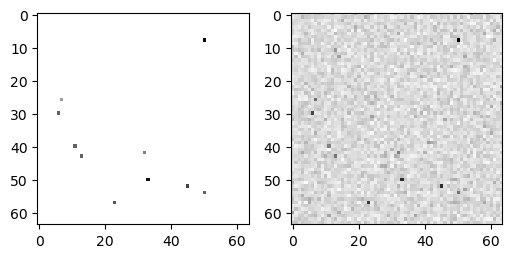

In [2]:
rng = default_rng(38456809)
n1,n2 = 64,64
im_true = np.zeros((n1,n2))
n_peaks,mean_peak = 10,15
S0,S1 = rng.integers(n1,size=(n_peaks,)),rng.integers(n2,size=(n_peaks,))
H = rng.poisson(mean_peak,size=(n_peaks,))
for i in np.arange(n_peaks):
    im_true[S0[i],S1[i]] = H[i]
# draw a noisy version of u_true by adding normally distributed noise
std_noise = 2
im_noisy = im_true + rng.normal(loc=0,scale=std_noise,size=(n1,n2))
fig,ax = plt.subplots(1,2,figsize=(6,13))
ax[0].imshow(im_true,cmap='Greys')
ax[1].imshow(im_noisy,cmap='Greys')
plt.show()

**Define the posterior distribution**\
Assume the posterior distribution is $\exp(-V(u)) = \exp(-(F(u)+G(u)))$ where $F(u) = \frac{1}{2\sigma^2}\lVert u-u_{\text{noisy}} \rVert_2^2$ and $G(u) = \alpha \lVert u \rVert_1$.\
Define the posterior distribution here and compute the MAP estimate $$\hat{u} = \arg\max_u \exp(-V(u)) = \arg\min_u \{F(u)+G(u)\}.$$

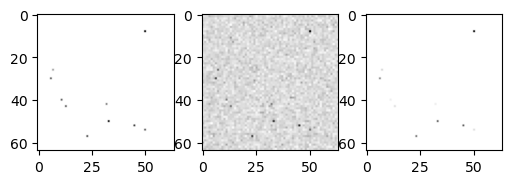

True support:
[ 8 26 30 40 42 43 50 52 54 57]
[50  7  6 11 32 13 33 45 50 23]
Denoised support:
[ 8 26 30 40 42 43 50 52 54 57]
[50  7  6 11 32 13 33 45 50 23]


In [3]:
u_noisy = np.reshape(im_noisy,(-1,1))
mu_l1 = 2
posterior = pds.L2Loss_SparsityReg(n1*n2,l2shift=u_noisy,l2scale=std_noise,l1reg=mu_l1)
# metaparameter of the distribution: L = Lipschitz constant of nabla F
L = 1/std_noise**2

"""<><><> compute the MAP using FISTA and check that it properly denoises the image <><><>"""
u_fista = u_noisy
v_fista = u_fista
iter_fista, tau_fista = 50, std_noise**2
t = 1
for k in np.arange(iter_fista):
    # gradient forward step
    w = v_fista - tau_fista*1/std_noise**2 * (v_fista-u_noisy)
    # proximal gradient backward step
    u_new = np.maximum(np.abs(w)-tau_fista*mu_l1, 0) * np.sign(w)
    t_new = (1+np.sqrt(1+4*t**2))/2
    v_fista = u_new + (t-1)/t_new * (u_new-u_fista)
    u_fista = u_new
    t = t_new

u_map = u_fista
im_map = np.reshape(u_map,(n1,n2))
fig,ax = plt.subplots(1,3,figsize=(6,19))
ax[0].imshow(im_true,cmap='Greys')
ax[1].imshow(im_noisy,cmap='Greys')
ax[2].imshow(im_map,cmap='Greys')
plt.show()
print('True support:')
print(np.nonzero(im_true)[0])
print(np.nonzero(im_true)[1])
print('Denoised support:')
print(np.nonzero(im_map)[0])
print(np.nonzero(im_map)[1])

**Sample once using Px-MALA to have an unbiased estimate of the target for the Wasserstein estimates**

In [4]:
tau_pxmala = 0.9/L
max_iter_pxmala = 100
n_samples_pxmala = 1
# initialize at the MAP to minimize burn-in time
x0_pxmala = u_map*np.ones((1,n_samples_pxmala))
pxmala = PxMALA(max_iter_pxmala, tau_pxmala, x0_pxmala, pd = posterior)

x_pxmala = pxmala.simulate(return_all=True)
x_pxmala_hist = np.reshape(x_pxmala[:,:,100:1000], (-1,))
plt.hist(x_pxmala_hist,100,density=True);
plt.plot(np.reshape(t,(-1,)),np.reshape(dens_vals,(-1,)), color='r',label='pdf');
plt.xlim(-0.4, 3);  plt.ylim(0,2.2);

/Users/lorenzkuger/NextcloudFAUMADS/phdErlangen/NoMADS Cambridge/code/python/pxmala.py:83: RuntimeWarning: invalid value encountered in true_divide
  p = np.minimum(1,self.targetpdf(x_proposal)/self.targetpdf(self.x)*np.reshape(q1/q2,(1,-1)))
/Users/lorenzkuger/NextcloudFAUMADS/phdErlangen/NoMADS Cambridge/code/python/pxmala.py:83: RuntimeWarning: divide by zero encountered in true_divide
  p = np.minimum(1,self.targetpdf(x_proposal)/self.targetpdf(self.x)*np.reshape(q1/q2,(1,-1)))


ValueError: p < 0, p > 1 or p contains NaNs

**Sample using PSGLA and inexact PSGLA**

In [49]:
# same parameters for both samplers
tau = 0.9/L
max_iter = int(np.max((50,np.round(0.3/tau))))
n_samples = 1000
x0 = 10*np.ones((1,n_samples)) #np.mean(D)*np.ones((1,n_samples))

# psgla
pla = PSGLA(max_iter, tau, x0, pd = posterior)
x_pla, W2dist_pla = pla.simulate(x_comp = x_pxmala[:,:,100:1000],return_all=True)

# inexact prox psgla
epsilon = 0.1
ipla = IPSGLA(max_iter, tau, x0, epsilon, pd=posterior)
x_ipla, W2dist_ipla = ipla.simulate(x_comp = x_pxmala[:,:,100:1000],return_all=True)

**Compare samples**

In [50]:
# histograms of samples
x_pxmala_hist = np.reshape(x_pxmala[:,:,100:1000], (-1,))
x_pla_hist = np.reshape(x_pla, (n_samples,1,max_iter+1))
x_ipla_hist = np.reshape(x_ipla, (n_samples,1,max_iter+1))

def hist_iterates(k=max_iter):
    fig, ax = plt.subplots(1, 3, figsize=(25,5))
    ax[0].set_xlim(-0.4, 3);  ax[0].set_ylim(0,2.2);
    
    pdf_plot_pxmala = ax[0].plot(np.reshape(t,(-1,)),np.reshape(dens_vals,(-1,)), color='r',label='pdf')
    ax[0].set_title('Px-MALA (unbiased sampling)');
    pdf_plot_psgla = ax[1].plot(np.reshape(t,(-1,)),np.reshape(dens_vals,(-1,)), color='r',label='pdf')
    ax[1].set_title('PLA');
    pdf_plot_myula = ax[2].plot(np.reshape(t,(-1,)),np.reshape(dens_vals,(-1,)), color='r',label='pdf')
    ax[2].set_title('inexact PLA, errors = {:.3e}'.format(epsilon));

    hist_gt = ax[0].hist(x_pxmala_hist, 100, density=True);
    hist_pla = ax[1].hist(x_pla_hist[:,:,k], 100, density=True);
    ax[1].set_xlim(-0.4, 3);  ax[1].set_ylim(0,2.2);
    hist_ipla = ax[2].hist(x_ipla_hist[:,:,k], 100, density=True);
    ax[2].set_xlim(-0.4, 3);  ax[2].set_ylim(0,2.2);
interact(hist_iterates, k=(0,max_iter))
#hist_iterates()

interactive(children=(IntSlider(value=50, description='k', max=50), Output()), _dom_classes=('widget-interact'…

<function __main__.hist_iterates(k=50)>

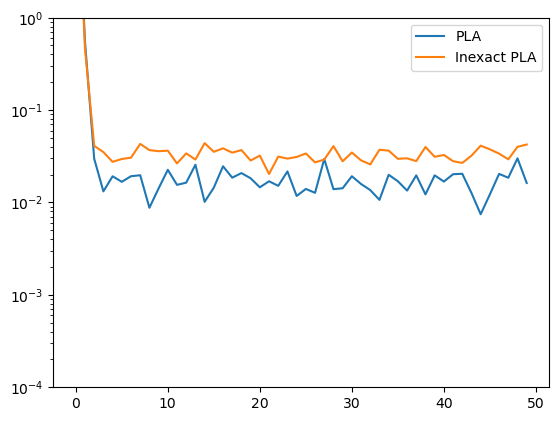

In [51]:
plt.semilogy(W2dist_pla[0:max_iter], label='PLA')
plt.semilogy(W2dist_ipla[0:max_iter], label='Inexact PLA')
plt.legend()
plt.ylim(1e-4,1e0);

In [52]:
lambdaF = L
print('Predicted maximum additional error due to prox inexactness: {:.2e}'.format(2*epsilon/lambdaF))

Predicted maximum additional error due to prox inexactness: 1.00e-01
